In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import wilcoxon
import numpy as np

In [3]:
models = ["mbert","mbert-ro-bio","mbert-nl-clin", "mbert-nl-ro"]
tasks = ["NER"]
num_folds = 10 # number of cross validation folds
results = []

# append all the cross-validation results to a joint dataframe 
for model in models:
  for task in tasks:
    for fold in range(num_folds):
        with open(f'{model}/predict_fold_{fold}_results.json') as f:
            fold_result = json.load(f)
            result = {
              'model': model,
              'task': task,
              'fold': fold,
              'f1': round(fold_result['predict_f1'], 3),
              'precision': fold_result['predict_precision'],
              'recall': fold_result['predict_recall'],
              'accuracy': fold_result['predict_accuracy']
            }
            results.append(result)
result_df = pd.DataFrame(results)

In [7]:
from scipy import stats

def compute_ci(series, confidence=0.95):
    mean = series.mean()
    sem = stats.sem(series)
    ci = stats.t.interval(confidence, len(series)-1, loc=mean, scale=sem)
    return pd.Series({"mean": mean, "ci_low": ci[0], "ci_high": ci[1]})

ci_df = result_df.groupby("model")["f1"].apply(compute_ci).reset_index()
ci_df


,model,level_1,f1
0,mbert,mean,0.731800
1,mbert,ci_low,0.705013
2,mbert,ci_high,0.758587
3,mbert-nl-clin,mean,0.717500
4,mbert-nl-clin,ci_low,0.694445
5,mbert-nl-clin,ci_high,0.740555
6,mbert-nl-ro,mean,0.756200
7,mbert-nl-ro,ci_low,0.731351
8,mbert-nl-ro,ci_high,0.781049
9,mbert-ro-bio,mean,0.768000


/var/folders/z2/_1pt2jfd5216hfcmv5xkx2gw0000gn/T/ipykernel_31787/2107695826.py:17: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data = median_df, x = 'model', y = 'f1', color = 'red', markers = 'D', scale = 1.0, join = True, linestyles = '-', errorbar = None)
/var/folders/z2/_1pt2jfd5216hfcmv5xkx2gw0000gn/T/ipykernel_31787/2107695826.py:17: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data = median_df, x = 'model', y = 'f1', color = 'red', markers = 'D', scale = 1.0, join = True, linestyles = '-', errorbar = None)


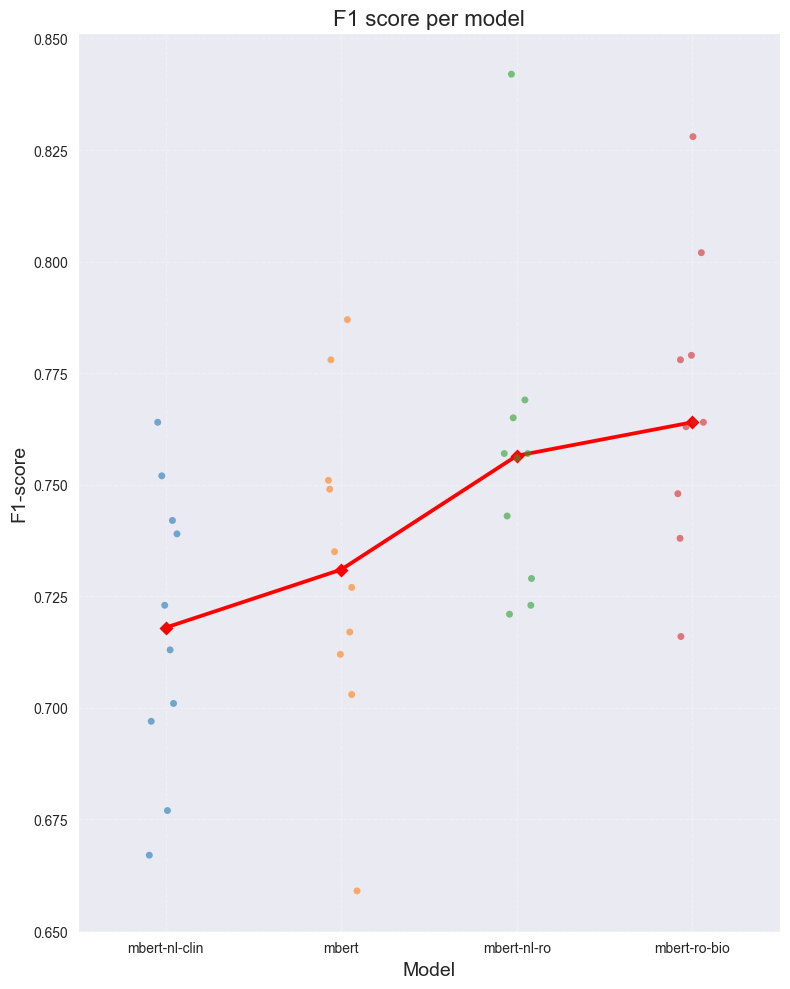

In [8]:

plt.figure(figsize = (8,10))

median_df = result_df.groupby('model', as_index = False)['f1'].median()
median_df = median_df.sort_values("f1", ascending = True)

model_order = median_df["model"].tolist()
result_df["model"] = pd.Categorical(result_df["model"], categories = model_order, ordered = True)
median_df["model"] = pd.Categorical(median_df["model"], categories = model_order, ordered = True)

sns.stripplot(data = result_df, 
              x = 'model', 
              y = 'f1', 
              hue = 'model',
              jitter = True, 
              alpha = 0.6)

sns.pointplot(data = median_df, x = 'model', y = 'f1', color = 'red', markers = 'D', scale = 1.0, join = True, linestyles = '-', errorbar = None)

plt.title("F1 score per model", fontsize = 16)
plt.xlabel("Model", fontsize = 14)
plt.ylabel("F1-score", fontsize = 14)
plt.grid(True, linestyle = '--', alpha = 0.3)

plt.savefig("F1_per_model.png", dpi=300)
plt.tight_layout()
plt.show()

In [6]:
result_df.groupby(['model'], observed = True).agg({'f1':'median',})

,f1
model,
mbert-nl-clin,0.7180
mbert,0.7310
mbert-nl-ro,0.7565
mbert-ro-bio,0.7640


In [7]:
result_df.groupby(['model'], observed = True).agg({'f1':'mean'})

,f1
model,
mbert-nl-clin,0.7175
mbert,0.7318
mbert-nl-ro,0.7562
mbert-ro-bio,0.7680


In [11]:
def wilcoxon_precision_test(result_df, model_a, model_b, alternative='two-sided'):
    print(f"Wilcoxon Signed-Rank Test between {model_a} and {model_b} (f1):")

    pivoted = result_df.pivot(index='fold', columns='model', values='f1')
    
    if model_a not in pivoted.columns or model_b not in pivoted.columns:
        print("One or both models not found in result_df.")
        return

    precision_a = pivoted[model_a].values
    precision_b = pivoted[model_b].values

    stat, p_value = wilcoxon(precision_a, precision_b, zero_method='pratt', alternative=alternative)
    print(f"Wilcoxon test statistic = {stat:.4f}, p-value = {p_value:.4f}")


In [12]:
model_names = result_df["model"].unique()

for m1, m2 in combinations(model_names, 2):
    f1_1 = result_df[result_df["model"] == m1].sort_values("fold")["f1"].values
    f1_2 = result_df[result_df["model"] == m2].sort_values("fold")["f1"].values

    keep_idx = np.argsort(f1_1 - f1_2)[1:-1]
    f1_1_trimmed = f1_1[keep_idx]
    f1_2_trimmed = f1_2[keep_idx]
    stat, p = wilcoxon(f1_1_trimmed, f1_2_trimmed)
    print(f"{m1} vs {m2} → p-value = {p:.4f}")

mbert vs mbert-ro-bio → p-value = 0.0078
mbert vs mbert-nl-clin → p-value = 0.1953
mbert vs mbert-nl-ro → p-value = 0.0156
mbert-ro-bio vs mbert-nl-clin → p-value = 0.0078
mbert-ro-bio vs mbert-nl-ro → p-value = 0.3125
mbert-nl-clin vs mbert-nl-ro → p-value = 0.0078


In [14]:
models = result_df["model"].unique()
model_list = models.to_list()

p_matrix = pd.DataFrame(np.ones((len(model_list), len(model_list))), index = model_list, columns = model_list)

for m1, m2 in combinations(model_names, 2):
    f1_1 = result_df[result_df["model"] == m1].sort_values("fold")["f1"].values
    f1_2 = result_df[result_df["model"] == m2].sort_values("fold")["f1"].values

    stat, p = wilcoxon(f1_1, f1_2)
    print(f"{m1} vs {m2} → p-value = {p:.4f}")

    p_matrix.loc[m1, m2] = p
    p_matrix.loc[m2, m1] = p

p_matrix = p_matrix.round(4)
display(p_matrix)

mbert vs mbert-ro-bio → p-value = 0.0039
mbert vs mbert-nl-clin → p-value = 0.3223
mbert vs mbert-nl-ro → p-value = 0.0195
mbert-ro-bio vs mbert-nl-clin → p-value = 0.0039
mbert-ro-bio vs mbert-nl-ro → p-value = 0.3750
mbert-nl-clin vs mbert-nl-ro → p-value = 0.0020


/var/folders/z2/_1pt2jfd5216hfcmv5xkx2gw0000gn/T/ipykernel_31787/2330677965.py:2: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  model_list = models.to_list()


,mbert,mbert-ro-bio,mbert-nl-clin,mbert-nl-ro
mbert,1.0000,0.0039,0.3223,0.0195
mbert-ro-bio,0.0039,1.0000,0.0039,0.3750
mbert-nl-clin,0.3223,0.0039,1.0000,0.0020
mbert-nl-ro,0.0195,0.3750,0.0020,1.0000


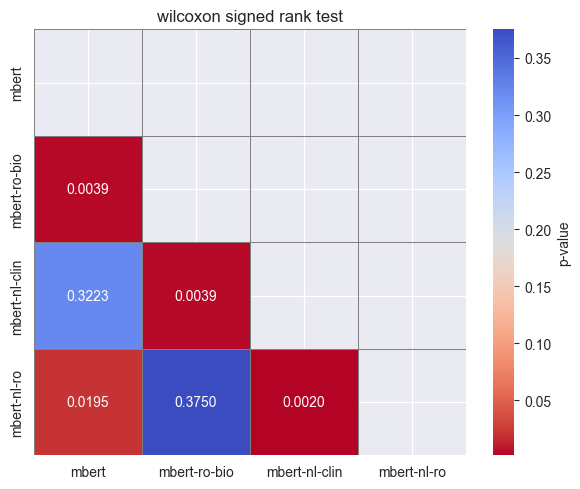

In [15]:
plt.figure(figsize = (6,5))

sns.heatmap(
    p_matrix,
    annot = True, fmt = ".4f", cmap = "coolwarm_r", cbar_kws = {'label': 'p-value'},
    linewidths = 0.5, linecolor = "grey",
    mask = np.triu(np.ones_like(p_matrix, dtype = bool))
)

plt.title("wilcoxon signed rank test")

plt.savefig("p-value.png", dpi=300)
plt.tight_layout()
plt.show()